NOTE:
Since the direct showing of animated gifs does not seem to work in github directly, I have included the gifs as external files

In [13]:
#This program uses simple principal component analysis and linear discriminant analysis 
#to classify hand written digits and plot them

#The notebook may have some errors if both the LDA and PCA animations are running the same time

#Data Set Information: https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits
#We used preprocessing programs made available by NIST to extract normalized bitmaps of handwritten
#digits from a preprinted form. From a total of 43 people, 30 contributed to the training set and different
#13 to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of 4x4 and the number
#of on pixels are counted in each block. This generates an input matrix of 8x8 where each element
#is an integer in the range 0..16. This reduces dimensionality and gives invariance to small distortions. 
#For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G. T. Candela,
#D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson,
#NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.
#Attribute Information:
#All input attributes are integers in the range 0..16. 
#The last attribute is the class code 0..9

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from matplotlib.patches import Ellipse
from matplotlib import animation
from IPython.display import HTML

#matplotlib.use('TkAgg')
%matplotlib notebook

#define class for multivariate input
class Multivariate:
    
    def __init__(self, X):
        
        self.mean=np.mean(X, axis=0) #the mean value vector
        self.X=X-self.mean[np.newaxis,:] #center the data
        self.XT=np.transpose(self.X) #calculate the transpose
        self.covm=covm=np.cov(self.XT) #numpy wants samples as colums while in data they are rows
        self.samples,self.features=np.shape(X) #data size
        
    def PCA(self,k):
        #diagonalize
        self.covm_evalues, self.covm_evec= np.linalg.eigh(self.covm) #eigenvectors and eigenvalues of the covariance matrix
        
        #take first k highegs eigenvalue vectors (directions of highest vaiance in new basis)
        self.W=self.covm_evec[:,self.features-k:self.features] #k biggest eigenvectors as columns
        self.WT=np.transpose(self.W)
        self.WT=np.flipud(self.WT) #first row as highest eigenvalue,2nd as second and so on
        
        #coordinates in the new basis
        self.pcaZ=np.dot(self.WT,self.XT) #samples as rows
 
    def LDA(self,k,classifier):
        
        #-------first cut the data to classes-------
        self.digit_data=[]
        self.digit_means=np.zeros((10,self.features))
        self.digit_samplesize=np.zeros((10)) #separate digit data samples

        for digit_i in range(10):
            
            digit_i_data=[] #reset
            
            for i in range(self.samples):
                if classifier[i]==digit_i:
            
                    digit_i_data.append(self.X[i,:]) #a row is a sample
                
            #save each digit separately
            digit_i_data=np.asarray(digit_i_data) #make array from list
            digit_i_data=np.transpose(digit_i_data) #make each column as a sample, since numpy covarience calc wants that
            self.digit_data.append(digit_i_data)
                
            #calculate means
            self.digit_means[digit_i,:]=np.mean(digit_i_data, axis=1)
            self.digit_samplesize[digit_i]=np.shape(digit_i_data)[1]


        #------------calculate in class scatter matrices from calculation the covarience matrix inside a class
        
        self.digit_i_covm=[]
        self.SWT=np.zeros((self.features,self.features))
        self.SB=np.zeros((self.features,self.features))
        for digit_i in range(10):
        
            test=np.cov(self.digit_data[digit_i]) #covariance matrix for digit_i
            self.digit_i_covm.append(test) #gather covarieance matrices
            self.SWT=self.digit_i_covm[digit_i]+self.SWT #total within class scatter is the sum 
            
            #calculate next the between class scatter matrix
            mean_i=np.transpose(self.digit_means[digit_i,:])
            vector=mean_i-self.mean
            #in the following line, erase sample size N_i if all classes should have same separation from the mean
            self.SB=self.digit_samplesize[digit_i]*np.outer(vector,vector)+self.SB
        
        #the LDA directions are the largest eigenvectors of SWT^-1 SB, calculate those
        temp=np.linalg.inv(self.SWT)
        temp=temp*self.SB
        
        #diagonalize
        self.lda_evalues, self.lda_evec= np.linalg.eigh(temp)
        
        #take first k highegs eigenvalue vectors (directions of highest class separation in lda)
        self.lda_W=self.lda_evec[:,self.features-k:self.features] #k biggest eigenvectors as columns
        self.lda_WT=np.transpose(self.lda_W)
        self.lda_WT=np.flipud(self.lda_WT) #first row as highest eigenvalue,2nd as second and so on
        
        #coordinates in the new basis
        self.ldaZ=np.dot(self.lda_WT,self.XT) #samples as rows


#-------Load and Initialize data---------------------
data = np.loadtxt('dig_tra.txt')
classifier=data[:,64] #the last entry is the classifier, the digit (0-9)
data=data[:,0:64] # cut the classifier from data

#-----calculations--------

#reduce the dimension to 60 with PCA since the within class scatter matrix is not invertible and
#thus LDA cannot be directly used

#preliminary dimensionality reduction
Initialization=Multivariate(data) #call the multivariate class to perform standard operations

k=60
Initialization.PCA(k)
data=np.transpose(Initialization.pcaZ)

del Initialization
#------

#now perform PCA and LDA to dimension 2
k=2
Optdigit=Multivariate(data)
Optdigit.PCA(k)
Optdigit.LDA(k,classifier) #linear discriminant analysis




#POSTPROCESSING
#---------separate digits and means after PCA / LDA for printing purposes----------

#cut the digits to separate lists for plotting
digit_i_list_PCA=[]
list_i_PCA=[]
means_PCA=np.zeros((10,k))
std_PCA=np.zeros((10,k))

digit_i_list_LDA=[]
list_i_LDA=[]
means_LDA=np.zeros((10,k))
std_LDA=np.zeros((10,k))

for digit_i in range(10):
    for i in range(len(data)):
        if classifier[i]==digit_i:
            
            list_i_PCA.append(Optdigit.pcaZ[:,i])
            list_i_LDA.append(Optdigit.ldaZ[:,i])
    #save each digit as separate N x dimensions array
    list_i_PCA=np.asarray(list_i_PCA)
    digit_i_list_PCA.append(list_i_PCA)
    list_i_LDA=np.asarray(list_i_LDA)
    digit_i_list_LDA.append(list_i_LDA)
    #calculate means and variances
    means_PCA[digit_i,:]=np.mean(list_i_PCA, axis=0)
    std_PCA[digit_i,:]=np.std(list_i_PCA, axis=0)
    list_i_PCA=[]
    means_LDA[digit_i,:]=np.mean(list_i_LDA, axis=0)
    std_LDA[digit_i,:]=np.std(list_i_LDA, axis=0)
    list_i_LDA=[]


<IPython.core.display.Javascript object>


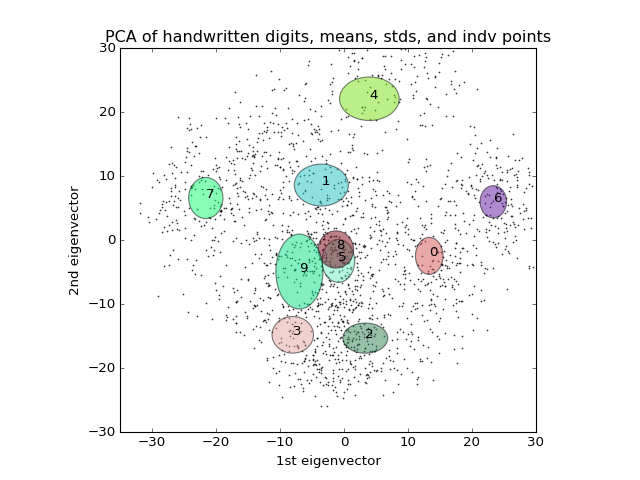

In [14]:
#Visualize PCA
NUM = 10
xy=means_PCA

ells = [Ellipse(xy[i,:], width=std_PCA[i,0], height=std_PCA[i,1])
        for i in range(NUM)]

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
plt.scatter(Optdigit.pcaZ[0,:],Optdigit.pcaZ[1,:],s=0.2)
plt.title('PCA of handwritten digits, means, stds, and indv points')
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')


for counter, e in enumerate(ells):
    plt.annotate(str(counter), xy[counter,:],xytext=(0,0),textcoords = 'offset points')
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.5)
    e.set_facecolor(np.random.rand(3))

    
ax.set_xlim(-35, 30)
ax.set_ylim(-30, 30)
plt.show()

In [ ]:
#____________ANIMATION PCA_________________

fig2 = plt.figure(1)
ax2 = fig2.add_subplot(111, aspect='equal')
plt.title('PCA of handwritten digits, means, stds, and indv points')
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')

ells2 = [Ellipse(xy[i,:], width=std_PCA[i,0], height=std_PCA[i,1])
        for i in range(NUM)]

for counter2, e2 in enumerate(ells2):
    plt.annotate(str(counter2), xy[counter2,:],xytext=(0,0),textcoords = 'offset points')
    ax2.add_artist(e2)
    e2.set_clip_box(ax2.bbox)
    e2.set_alpha(0.5)
    e2.set_facecolor(np.random.rand(3))

    
ax2.set_xlim(-35, 30)
ax2.set_ylim(-30, 30)
bbox_props = dict(boxstyle="round,pad=0.4", fc="cyan", ec="b", lw=2)

graph, = plt.plot([], [], 'o',markersize=2)

def init():
    graph.set_data([], [])
    return graph

def animate(i):

    graph.set_data(digit_i_list_PCA[i][:,0],digit_i_list_PCA[i][:,1])    
    text="Digit " + str(i)   
    t = ax2.text(20, -22, text, ha="center", va="center",size=15, bbox=bbox_props)
   
    return graph

ani = animation.FuncAnimation(fig2, animate, init_func=init, frames=10, interval=1000, blit=False)
ani.save('Optdigits_PCA.gif', fps=1,writer='imagemagick')

![alt text](Optdigits_PCA.gif "PCA gif")

<IPython.core.display.Javascript object>


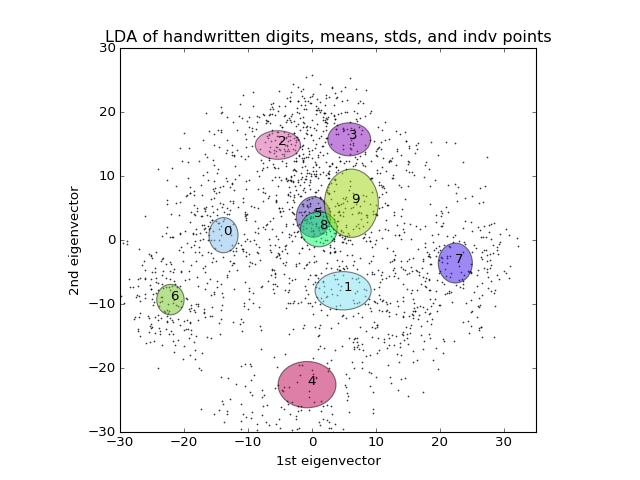

In [15]:
#visualize LDA
NUM=10
xy=means_LDA

ells3 = [Ellipse(xy[i,:], width=std_LDA[i,0], height=std_LDA[i,1])
        for i in range(NUM)]

fig3 = plt.figure(10)
ax3 = fig3.add_subplot(111, aspect='equal')
plt.scatter(Optdigit.ldaZ[0,:],Optdigit.ldaZ[1,:],s=0.2)
plt.title('LDA of handwritten digits, means, stds, and indv points')
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')



for counter3, e3 in enumerate(ells3):
    plt.annotate(str(counter3), xy[counter3,:],xytext=(0,0),textcoords = 'offset points')
    ax3.add_artist(e3)
    e3.set_clip_box(ax3.bbox)
    e3.set_alpha(0.5)
    e3.set_facecolor(np.random.rand(3))

    
ax3.set_xlim(-30, 35)
ax3.set_ylim(-30, 30)
plt.show()

In [ ]:
#____________ANIMATION LDA_________________

fig4 = plt.figure(11)
ax4 = fig4.add_subplot(111, aspect='equal')
plt.title('LDA of handwritten digits, means, stds, and indv points')
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')

ells4 = [Ellipse(xy[i,:], width=std_LDA[i,0], height=std_LDA[i,1])
        for i in range(NUM)]

for counter, e in enumerate(ells4):
    plt.annotate(str(counter), xy[counter,:],xytext=(0,0),textcoords = 'offset points')
    ax4.add_artist(e)
    e.set_clip_box(ax4.bbox)
    e.set_alpha(0.5)
    e.set_facecolor(np.random.rand(3))

    
ax4.set_xlim(-35, 30)
ax4.set_ylim(-30, 30)
bbox_props = dict(boxstyle="round,pad=0.4", fc="cyan", ec="b", lw=2)

graph, = plt.plot([], [], 'o',markersize=2)

def init2():
    graph.set_data([], [])
    return graph

def animate2(i):

    graph.set_data(digit_i_list_LDA[i][:,0],digit_i_list_LDA[i][:,1])    
    text="Digit " + str(i)   
    t = ax4.text(20, -22, text, ha="center", va="center",size=15, bbox=bbox_props)
   
    return graph

ani = animation.FuncAnimation(fig4, animate2, init_func=init2, frames=10, interval=1000, blit=False)
ani.save('Optdigits_LDA.gif', fps=1,writer='imagemagick')

![alt text](Optdigits_LDA.gif "LDA Gif")